
# Лабораторная 7

## Вариант 6

## Условие задания
В однопроцессорную  систему случайным образом поступают на выполнение $m$ разных типов программ, отличающихся известной трудоемкостью $Q_1, Q_2, \ldots, Q_m$. Входящий поток простейший с интенсивностью $\lambda$.

Представив данную систему как одноканальную СМО с неограниченной очередью, вычислить среднее время обслуживания программ, считая длительность обслуживания случайной величиной (теоретически и экспериментально).

Реализовать алгоритм SPT, выбирая из очереди заявки в соответствии с их приоритетом по трудоемкости. Рассчитать среднее время обслуживания программ. Сравнить полученные результаты.

Реализовать алгоритм RR при заданном кванте времени $q$. Оценить среднее время обслуживания программ. Сравнить полученные результаты. Выяснить, как влияет величина кванта на среднее время обслуживания программ.


## Пояснения преподавателя

Смоделировать 1 канальную СМО с бесконечной очередью. Вычислить среднюю трудоемкость, расчитать через нее интенсивность обслуживания (мю). Посчитать среднее время обслуживания программ (Тсист).

Практика может отличиться от теории, потому что теоретически мы находим $\mu_{ср}$ от бесконечного числа заявок, в в эксперименте число заявок ограничено.

2 часть - это реализация алгоритма STP - очередь с приоритетами

## Теоретическое решение

У нас **одноканальная система с неограниченной очередью**. Лекция 3.

> Среднее время обслуживания

Из лекции 6:

> В однопроцессорной системе с неоднородными заявками среднее время обслуживания - Среднее время обслуживания складывается из ожидания в очереди и времени выполнения, усредненным по всем заявкам

т.е. это $T_{sist}$

$$\rho=\frac{\lambda}{\mu}$$


$$T_{\text{сист}}=\frac{1}{\mu(1-\rho)}=\frac{1}{\mu-\lambda}\tag{лек-3}$$

In [190]:
Variant<-6
set.seed(Variant) 
m<-sample(c(6:20), 1)
lambda<-runif(1, 0.1, 2)
Q<-rexp(m, 0.3)
q<-sample(c(1:4), 1)
View(data.frame(m, q, lambda))
print(Q)

m  q lambda 
1 10 4 1.88152

 [1] 2.5018515 4.0450762 2.0498893 1.1775382 7.0369009 0.9571518 0.2200340
 [8] 1.7995447 2.3890709 0.1193048


$$\mu_{ср} = \frac{1}{Q_{ср}} = \frac{n}{\sum_{i=1}^{q}{q_i}}$$

In [191]:
mu <- length(Q)/sum(Q); mu; '<'; lambda

[1] 0.4485037

[1] "<"

[1] 1.88152

у меня $\mu_{ср}$ значительно меньше $\lambda$, поэтому очередь будет расти до бесконечности. **$\lambda$ нужно уменьшить**.

> Пусть $\lambda = 0,3$

In [192]:
lambda = 0.3

table <- data.frame()
table<-rbind(table, c(
  1/(mu-lambda),
  rep(NA, times=3)
))
rownames(table) <- c("Tsist")
colnames(table) <- c("Теория", "Эксперимент", "STP", paste0("RR (q=", as.character(q), ')'))
View(table)

Теория   Эксперимент STP RR (q=4)
Tsist 6.733841 NA          NA  NA

## Экспериментальное решение

### Приближение к одноканальной СМО с беск очередью M/M/1/m

Подойдет эксперимент из Лаб-3

In [193]:

experiment1 <- function(lambda, mu, N, DEBUG=F) {
  set.seed(Variant)

  event_task_recieve <- vector(mode='double', length=N)
  event_server_free <- vector(mode='double', length=N)
  event_wait_time <- vector(mode='double', length=N)
  event_queue_decrease_times <- vector(mode='double', length=N)

  time_free <- 0     # время от начала моделирования, когда сервер освободится и будет готов обработать программу 
  time_recieved <- 0 # время получения задачи
  time_required <- 0 # необходимое время для прогона программы

  for (i in 1:N) {
    time_recieved <- time_recieved + rexp(1, lambda)
    event_task_recieve[i] <- time_recieved
    time_required <- rexp(1, mu)

    if (time_free < time_recieved) {
      # будет выполняться сейчас
      time_free <- time_recieved + time_required
      event_wait_time[i] <- time_required # время выполнения
    } else {
      # будет выполняться после завершения предыдущей
      time_free <- time_free + time_required
      event_wait_time[i] <- time_free - time_recieved # время ожидания в очереди + время выполнения
      event_queue_decrease_times <- append(event_queue_decrease_times, time_free)
    }
    event_queue_decrease_times <- event_queue_decrease_times[event_queue_decrease_times > time_recieved]
    event_server_free[i] <- time_free
  }

  return(list(
    event_task_recieve = event_task_recieve,
    event_server_free = event_server_free,
    event_wait_time = event_wait_time
  ))
}

In [194]:
exp1_res <- experiment1(lambda, mu, 10e5)
table[2] <- mean(exp1_res$event_wait_time)
View(table)

Теория   Эксперимент STP RR (q=4)
Tsist 6.733841 6.716562    NA  NA

### STP

Отсортирую Q, чтобы приоритет соответствовал легкости/трудности

In [195]:
Q; Q <- sort(Q); Q

[1] 2.5018515 4.0450762 2.0498893 1.1775382 7.0369009 0.9571518 0.2200340
 [8] 1.7995447 2.3890709 0.1193048

[1] 0.1193048 0.2200340 0.9571518 1.1775382 1.7995447 2.0498893 2.3890709
 [8] 2.5018515 4.0450762 7.0369009

Понадобятся следующие методы для работы с очередью с приоритетом. Для SPT и RR приоритетнее тот, чьи проиоритет/время меньше.

In [196]:
create_queue<-function() {
  return(list(idx = c(), prior = c(), time = c()))
}

create_request<-function(idx, m, time) {
  return(list(idx = idx, prior = sample(1:m, 1), time = time))
}

push<-function(queue, idx, prior, time) {
  append(queue$idx, idx)
  append(queue$prior, prior)
  append(queue$time, time)
  return(queue)
}

remove<-function(queue, idx) {
  return(list(
    idx = queue$idx[-idx],
    prior = queue$prior[-idx],
    time = queue$time[-idx]
  ))
}

unshift<-function(queue) {
  return(remove(queue, 1))
}

pop_most_prior<-function(queue) {
  i <- which.min(queue$prior)
  return(list(
    most_prior = list(
      idx = queue$idx[i],
      prior = queue$prior[i],
      time = queue$time[i]
    ),
    queue = remove(queue, i)
  ))
}

# Проверка

# queue1 <- list(idx = c(1:3), prior = c(7,1,2))
# queue2 <- list(idx = c(1), prior = c(7))
# queue3 <- list(idx = c(), prior = c())

# queue1; queue1 <- unshift(queue1); queue1
# queue3; queue3 <- unshift(queue3); queue3

# queue1; get_most_prior(queue1)
# queue2; get_most_prior(queue2)
# queue3; get_most_prior(queue3)

# queue1; queue1 <- remove(queue1, 3); queue1
# queue2; queue2 <- remove(queue2, 1); queue2
# queue3; queue3 <- remove(queue3, 1); queue3


In [197]:
experiment2 <- function(lambda, Q, N, DEBUG=F) {
  set.seed(Variant)

  event_wait_time <- vector(mode='double', length=N)
  time <- 0

  requests <- list(idx = c(1:N), prior = sample(c(1:length(Q)), N, replace=TRUE), time = rexp(N, lambda))
  for (i in 1:N) {
    time <- time + requests$time[i]
    requests$time[i] <- time
  }
  time <- 0

  time_free <- 0     # время от начала моделирования, когда сервер освободится и будет готов обработать программу 
  time_recieved <- 0 # время получения задачи
  time_required <- 0 # необходимое время для прогона программы

  queue <- create_queue()

  i <- 1         # номер текущей / следующей задачи
  done_cnt <- 1  # счетчик выполненных задач

  while (T) {
    time_recieved <- requests$time[i]

    scenario <- which.min(c(time_free, time_recieved, Inf))
    if (scenario == 1) {
      time <- time_free
      # выполнить из очереди или простой
      if (length(queue$idx)) {
        pop_result <- pop_most_prior(queue)
        cur_request <- pop_result$most_prior
        queue <- pop_result$queue
        time_free <- time + Q[cur_request$prior]

        event_wait_time[done_cnt] <- time_free - cur_request$time  # время ожидания в очереди + время выполнения
        done_cnt <- done_cnt + 1
      } else {
        # очередь разобрали

        if (is.na(time_recieved)) {
          # попали сюда, когда time_recieved == NA и очереди нет -> выход
          print("все")
          break
        }

        # перематываю на время, когда выполнится ближайшая задача
        time_free <- time_recieved + Q[requests$prior[i]]

        event_wait_time[done_cnt] <- time_free - time_recieved
        done_cnt <- done_cnt + 1
        i <- i + 1
      }
    } else if (scenario == 2) {
      time <- time_recieved
      # встает в очередь или будет выполняться сейчас
      if (length(queue$idx)) {
        queue <- push(queue, requests$idx[i], requests$prior[i], requests$time[i])
      } else {
        time_free <- time + Q[requests$prior[i]]
        event_wait_time[done_cnt] <- time_free - time_recieved
        
        done_cnt <- done_cnt + 1
      }
      i <- i + 1
    }
  }

  return(list(
    event_wait_time = event_wait_time
  ))
}

In [198]:
exp2_res <- experiment2(lambda, Q, 1000000)

table[3] <- mean(exp2_res$event_wait_time[exp2_res$event_wait_time > 0])
View(table)


[1] "все"


Теория   Эксперимент STP      RR (q=4)
Tsist 6.733841 6.716562    2.229094 NA

### RR(R)

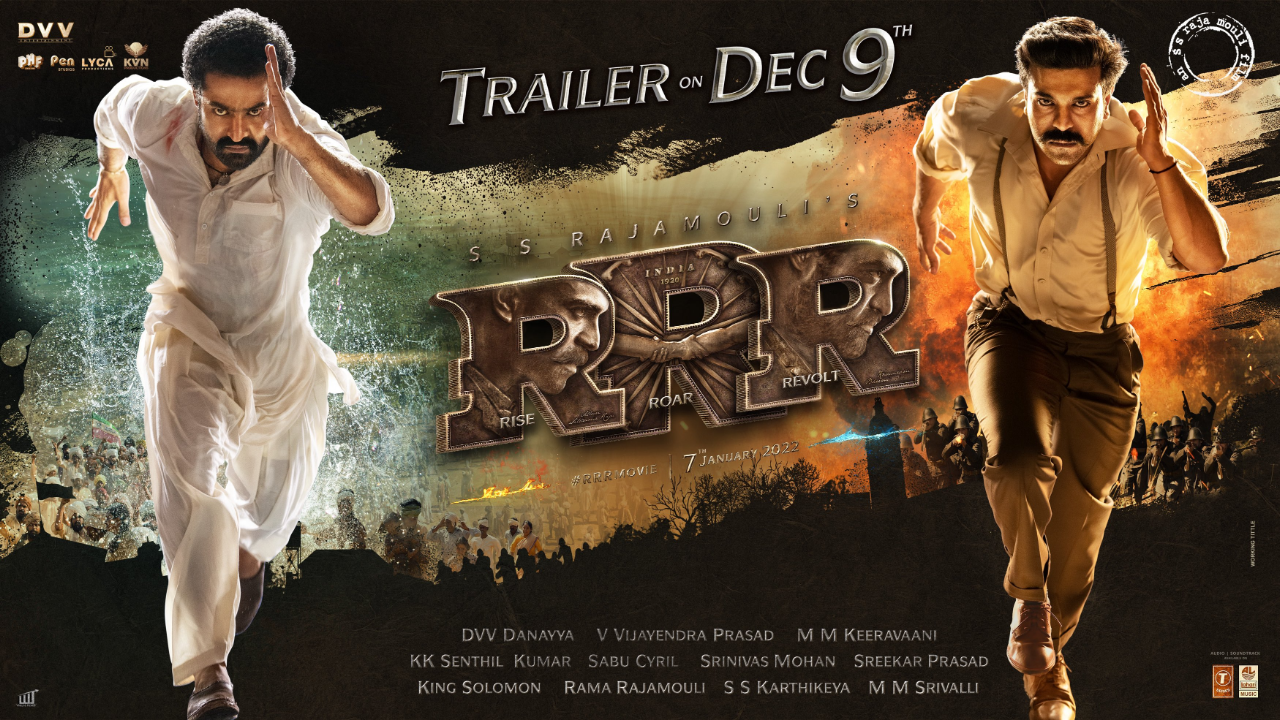

я очень хитрый, и теперь в приоритете храню не приоритет, а время Q[prior] или меньше, которое осталось для довыполнения заявки

In [199]:
experiment3 <- function(lambda, Q, q, N) {
  ti <- 0.01      # шаг времени
  T <- N * ti     # максимальноевремя моделирования 
  time <- 0       # текущее врем
  q_end_time <- 0 # время, когда истечет текущий квант времени q цикла обработки

  # Храню в формате: list(
  #   idx=номер,
  #   proc_left=время, оставшееся до того, как заявка будет считаться выполненной, (от Qi до 0)
  #   time=время прибытия заявки в систему, 
  #   done_at=время, когда заявка будет выполнена, если не прервется
  #)
  cur_request<- NULL
  queue <- create_queue()
  event_wait_time <- c()
  
  requests <- list(idx = c(1:N), prior = sample(Q, N, replace=TRUE), time = rexp(N, lambda))
  for (i in 1:N) {
    time <- time + requests$time[i]
    requests$time[i] <- time
  }
  time <- 0

  i <- 1

  while (time < T - ti) {
    time = time + ti

    if (time > requests$time[i] && !is.na(requests$time[i])) {
      # поступила новая заявка
      if (!is.null(cur_request)) {
        # сервер занят > заявка поступила в очередь
        queue <- push(queue, requests$idx[i], requests$prior[i], requests$time[i])
      } else {
        # заявка поступила сразу на сервер
        cur_request <- list(idx=requests$idx[i], proc_left=requests$prior[i], time=requests$time[i], done_at=requests$time[i] + requests$prior[i])
        q_end_time <- time + q
      }
      i <- i + 1
    }

    if (time > cur_request$done_at && !is.null(cur_request)) {
      # сервер выполнил заявку
      event_wait_time = append(event_wait_time, cur_request$done_at - cur_request$time)

      if (length(queue$idx)) {
        # если очередь не пуста, извлечь ПЕРВУЮ (а не более приоритетную pop_most_prior)
        cur_request <- list(idx=queue$idx[1], proc_left=queue$prior[1], time=queue$time[1], done_at=cur_request$done_at + queue$prior[1])
        queue = remove(queue, 1)
        q_end_time <- time + q
      } else {
        cur_request = NULL
      }
    }

    if (time > q_end_time && !is.null(cur_request) && length(queue$idx)) {
      # достигнут лимит выполнения программы на сервере q_end_time
      queue <- push(queue, cur_request$idx, cur_request$prior - q, cur_request$time)
      cur_request <- list(idx=queue$idx[1], proc_left=queue$prior[1], time=queue$time[1], done_at=queue$prior[1] + time)
      queue <- remove(queue, 1)
      q_end_time <- time + q
    }
  }

  return(list(
    event_wait_time = event_wait_time
  ))
}

In [200]:
exp3_res <- experiment3(lambda, Q, q, 10000000)
table[4] <- mean(exp3_res$event_wait_time[exp3_res$event_wait_time > 0])
View(table)

Теория   Эксперимент STP      RR (q=4)
Tsist 6.733841 6.716562    2.229094 2.231729

### Варьирование кванта q

$q={1,9}$

In [201]:
q_var_less <- vector(mode="double", length=3);
q_var_more <- vector(mode="double", length=5);
q_var_q <- table[4]

for (i in 1:(q-1)) {
  res_q_var <- experiment3(lambda, Q, i, 100000)$event_wait_time
  res_q_var <- res_q_var[res_q_var > 0]
  q_var_less[i] <- mean(res_q_var)
}

for (i in (q+1):(q+5)) {
  res_q_var <- experiment3(lambda, Q, i, 100000)$event_wait_time
  res_q_var <- res_q_var[res_q_var > 0]
  q_var_more[(i-q)] <- mean(res_q_var)
}

# удаляю старый q

table <- table[1:3]
table[(3 + 1):(3 + length(q_var_less) + 1 + length(q_var_more))] <- c(q_var_less, q_var_q, q_var_more);

colnames(table) <- c(colnames(table)[1:3], vapply(
  c(1:(length(q_var_less)+ 1 + length(q_var_more))),
  function(i) paste0('RR (q=', i, ')'),
  character(1)
))

View(table)

Теория   Эксперимент STP      RR (q=1) RR (q=2) RR (q=3) RR (q=4)
Tsist 6.733841 6.716562    2.229094 2.175701 2.120354 2.537387 2.231729
      RR (q=5) RR (q=6) RR (q=7) RR (q=8) RR (q=9)
Tsist 2.143049 2.263022 2.443088 2.240409 2.280104

## Выводы

Усредненное экспериментальное решение повторяет теоретическое усредненное.

Большой разницы между подходами SPT и RR при данных $\lambda$, $q$ и $Q$ не выявлено.

В методе RR наилучшее время показывает система с квантом $q=2$.